In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from community import community_louvain
from networkx.algorithms.community.centrality import girvan_newman

from tqdm import tqdm

In [2]:
adjacency_matrix = np.load('adjacency_matrix.npy')

data_recipe = pd.read_json('processed_data.json').reset_index(drop=True)

In [3]:
data_recipe.head(5)

,directions,fat,date,categories,calories,protein,rating,title,ingredients,sodium
0,[In a 1-pint jar with a tight-fitting lid comb...,32,2004-08-20 12:48:48,"[Cheese, Herb, Appetizer, Winter, Gourmet]",306,4,3.750,"Goat Cheese Marinated in Rosemary, Fennel, and...","[goat, seed, lemon, pepper, montrachet, crotti...",106
1,"[Preheat oven to 400°F with rack in middle., T...",7,2008-10-16 04:00:00,"[Side, Roast, Thanksgiving, Vegetarian, Dinner...",168,6,4.375,Parmesan-Roasted Butternut Squash,"[parmigiano-reggiano, cream, squash, piece, sage]",142
2,[Cut an X in bottom of each tomato with a shar...,102,2004-09-21 20:28:40,"[Beef, Potato, Tomato, Bake, Fall, Winter, Gou...",1303,42,3.125,Croatian Moussaka,"[tomato, onion, potato, parmigiano-reggiano, e...",713
3,[Heat oil in heavy large pot over medium-heat....,13,2004-09-21 20:28:11,"[Soup/Stew, Pasta, Shellfish, Tomato, Sauté, C...",396,47,4.375,Ann Pachett's Spicy Seafood Chowder,"[clam, onion, side, scallop, oil, shrimp, bell...",2133
4,[Thinly slice cabbage and onion separately. In...,5,2004-08-20 04:00:00,"[Onion, Side, Quick & Easy, Vinegar, Fall, Cab...",100,2,3.750,Wilted Red Cabbage with Balsamic Vinegar,"[onion, vinegar, sugar, oil, water, cabbage, p...",35


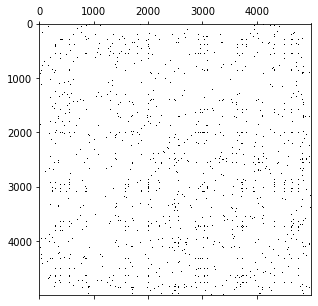

In [4]:
plt.figure(figsize=(5,5))
plt.spy(adjacency_matrix)
plt.show()

In [5]:
data_recipe.rating.value_counts()

4.375    2281
3.750    1437
5.000     675
3.125     396
2.500     147
1.250      42
1.875      22
Name: rating, dtype: int64

In [6]:
# Helper function for printing various graph properties
def describe_graph(G):
    print(nx.info(G))
    if nx.is_connected(G):
        print("Avg. Shortest Path Length: %.4f" %nx.average_shortest_path_length(G))
        print("Diameter: %.4f" %nx.diameter(G)) # Longest shortest path
    else:
        print("Graph is not connected")
        print("Diameter and Avg shortest path length are not defined!")
    print("Sparsity: %.4f" %nx.density(G))  # #edges/#edges-complete-graph
    # #closed-triplets(3*#triangles)/#all-triplets
    print("Global clustering coefficient aka Transitivity: %.4f" %nx.transitivity(G))

In [7]:
graph = nx.from_numpy_array(adjacency_matrix[:1000,:1000])

In [8]:
describe_graph(graph)

Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 9587
Average degree:  19.1740
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0192
Global clustering coefficient aka Transitivity: 0.3244


In [9]:
node_label_mapping = dict(zip(range(5000), data_recipe.title))

In [10]:
# add node attributes
nx.set_node_attributes(graph, data_recipe['protein'].to_dict(), 'protein')
nx.set_node_attributes(graph, data_recipe['fat'].to_dict(), 'fat')
nx.set_node_attributes(graph, data_recipe['sodium'].to_dict(), 'sodium')
nx.set_node_attributes(graph, data_recipe['calories'].to_dict(), 'calories')
nx.set_node_attributes(graph, data_recipe['rating'].to_dict(), 'rating')

In [11]:
print(node_label_mapping[0])
print(graph.node[0])

Goat Cheese Marinated in Rosemary, Fennel, and Hot Red Pepper 
{'protein': 4, 'fat': 32, 'sodium': 106, 'calories': 306, 'rating': 3.75}


In [12]:
# Helper function for visualizing signal on the graph
def visualize_graph(G, signal, with_labels=True, k=None, alpha=1.0, node_shape='o'):
    #nx.draw_spring(G, with_labels=with_labels, alpha = alpha)
    plt.figure(figsize=(15,8))
    pos = nx.spring_layout(G, k=k)
    if with_labels:
        lab = nx.draw_networkx_labels(G, pos, labels=dict([(n, n) for n in G.nodes()]))
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color=[G.nodes[n][signal] for n in G.nodes()], node_shape=node_shape)
    plt.colorbar(nc)
    plt.axis('off')

/Users/davitmartirosyan/anaconda3/envs/NTDS/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


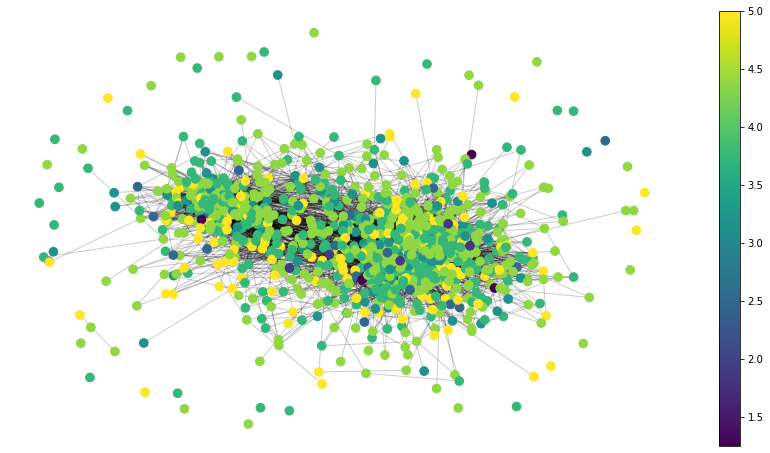

In [13]:
visualize_graph(graph,'rating',False, k=0.1, alpha=0.2, node_shape='.')

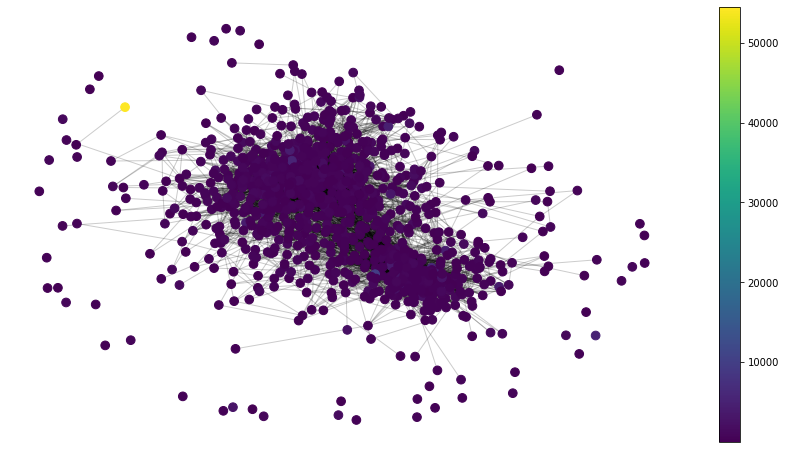

In [14]:
visualize_graph(graph,'calories',False, k=0.1, alpha=0.2, node_shape='.')

In [15]:
partition = community_louvain.best_partition(graph)
# add it as an attribute to the nodes
for n in graph.nodes:
    graph.nodes[n]["louvain"] = partition[n]

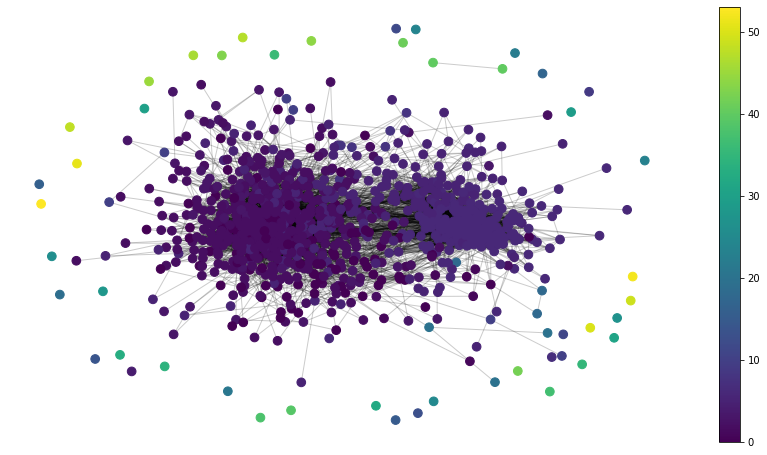

In [16]:
visualize_graph(graph,'louvain',False, k=0.1, alpha=0.2, node_shape='.')

In [17]:
from collections import Counter
Counter(partition.values())

Counter({0: 101,
         1: 8,
         2: 380,
         3: 75,
         4: 1,
         5: 175,
         6: 197,
         7: 1,
         8: 6,
         9: 1,
         10: 7,
         11: 1,
         12: 1,
         13: 1,
         14: 1,
         15: 1,
         16: 1,
         17: 1,
         18: 3,
         19: 1,
         20: 3,
         21: 1,
         22: 1,
         23: 1,
         24: 1,
         25: 1,
         26: 1,
         27: 1,
         28: 1,
         29: 1,
         30: 1,
         31: 1,
         32: 1,
         33: 1,
         34: 1,
         35: 1,
         36: 1,
         37: 1,
         38: 1,
         39: 1,
         40: 2,
         41: 1,
         42: 1,
         43: 1,
         44: 1,
         45: 1,
         46: 1,
         47: 1,
         48: 1,
         49: 1,
         50: 1,
         51: 1,
         52: 1,
         53: 1})

In [18]:
# Take all the nodes that belong to 2nd cluster
cluster_0 = [k for k in graph.nodes if partition[k] == 0]

In [19]:
for each in cluster_0:
        print(node_label_mapping[each],graph.node[each]['calories'])

Goat Cheese Marinated in Rosemary, Fennel, and Hot Red Pepper  306
Mashed Potatoes with Cheddar Cheese and Poblano Chilies  348
Sweet Potato and Sausage Gratin with Thyme  342
Clams au Gratin  105
Beef and Potato Pasties  356
Old-Fashioned Chicken and Corn Stew  452
Lobster Salad with Summer Vegetables  419
Pulled Corned Beef  1103
Spicy Ham Hash  577
Chicken and Corn Stew with Corn Wafers  744
Gravy Base  224
Vidalia Onion Pie  500
Spanish Pork Braise  646
Herbed Oven-Browned Potatoes  187
Black-Eyed Pea Curry  196
Brown Stock  67
Shoe String Potatoes (Pommes Pailles)  360
1985 Chicken Pie with Biscuit Crust  1261
Arctic Char with Cucumber-Feta Relish and Jalapeño-Goat Cheese Hush Puppies  460
Zucchini Potato Lemon-Thyme Mash  161
Fried Oysters with Holiday Tartar Sauce  1181
Blue and Red Flannel Hash  470
Potato, Onion and Caraway Cloverleaf Rolls  110
Braised Lamb Shanks with Caramelized Onions and Shallots  1095
Roast Goose with Chestnuts, Prunes and Armagnac  3052
Veal Stew (Blanq

In [20]:
nx.attribute_assortativity_coefficient(graph, 'calories')

-0.0022599951625912203

In [21]:
nx.attribute_assortativity_coefficient(graph, 'protein')

0.017998523407026023

In [22]:
nx.attribute_assortativity_coefficient(graph, 'fat')

0.01047536412191416

In [23]:
nx.attribute_assortativity_coefficient(graph, 'sodium')

-0.0007091516775854209

In [24]:
nx.attribute_assortativity_coefficient(graph, 'rating')

0.008644577338864

#### What are the main nutritional factors affecting people’s culinary preferences?

In [25]:
def rating_to_category(rating):
    if rating < 3:
        return 0 # low rating
    elif rating < 4:
        return 1 # medium rating
    else:
        return 2 # high rating

In [26]:
data_recipe['rating_categories'] = data_recipe['rating'].apply(rating_to_category)

In [27]:
data_recipe.rating_categories.value_counts()

2    2956
1    1833
0     211
Name: rating_categories, dtype: int64

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from scipy.sparse import csgraph

In [29]:
features = data_recipe[['fat','calories','protein','sodium']]
labels = data_recipe.rating_categories

In [30]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [31]:
X_train.shape,X_test.shape,X_val.shape

((4000, 4), (500, 4), (500, 4))

In [32]:
C = np.logspace(0,6)
scores = []

for c in C:
    model_logit = LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=1000, C=c, random_state=42)
    model_logit.fit(X_train,y_train)
    scores.append(model_logit.score(X_val,y_val))

In [33]:
c_best = C[np.argmax(scores)]
model_logit_best = LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=1000, C=c_best, random_state=42)
model_logit_best.fit(X_train,y_train)

LogisticRegression(C=138949.5494373136, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=42, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [34]:
train_acc =  model_logit_best.score(X_train,y_train)
val_acc =  model_logit_best.score(X_val,y_val)
test_acc =  model_logit_best.score(X_test,y_test)

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

Train accuracy 0.5923 | Validation accuracy 0.5980 | Test accuracy 0.5740


In [35]:
def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    eig_val, eig_vec = np.linalg.eigh(laplacian)
    idx = eig_val.argsort() 
    lamb = eig_val[idx]
    U = eig_vec[:,idx]
    return lamb,U

In [36]:
laplacian = csgraph.laplacian(adjacency_matrix,normed=True)
lam, U = spectral_decomposition(laplacian)
lam_max = np.max(lam)

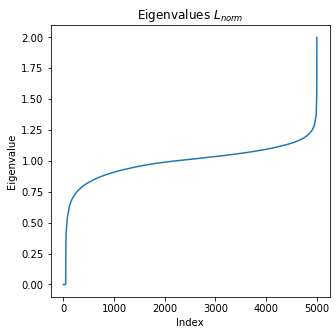

In [37]:
plt.figure(figsize=(5,5))
plt.plot(lam)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')
plt.show()

In [38]:
ideal_filter = np.ones((5000,))
ideal_filter[lam >= 0.2] = 0

In [39]:
def fit_polynomial(lam: np.ndarray, order: int, spectral_response: np.ndarray):
    """ Return an array of polynomial coefficients of length 'order'."""
    V = np.vander(lam,N=order,increasing=True)
    return np.linalg.lstsq(V,spectral_response)[0]

In [40]:
def polynomial_graph_filter_response(coeff: np.array, lam: np.ndarray):
    """ Return an array of the same shape as lam.
        response[i] is the spectral response at frequency lam[i]. """
    V = np.vander(lam,N=coeff.shape[0],increasing=True)
    return np.dot(V,coeff)

In [41]:
def polynomial_graph_filter(coeff: np.array, laplacian: np.ndarray):
    """ Return the laplacian polynomial with coefficients 'coeff'. """
    L_k = [np.linalg.matrix_power(laplacian,k) for k in range(len(coeff))]
    res = np.zeros(laplacian.shape)
    for index,each in enumerate(L_k):
        res+=coeff[index]*each
    return res

In [42]:
order = 7

coeff = fit_polynomial(lam, order, ideal_filter)
graph_filter = polynomial_graph_filter(coeff, laplacian)

/Users/davitmartirosyan/anaconda3/envs/NTDS/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


Text(0, 0.5, 'Spectral response')

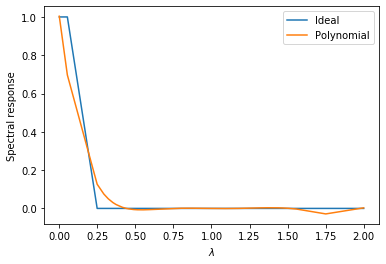

In [43]:
plt.plot(lam, ideal_filter)
plt.plot(lam, polynomial_graph_filter_response(coeff, lam))
plt.legend(['Ideal', 'Polynomial'])
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')

In [44]:
new_features = graph_filter @ features

X_train, X_test, y_train, y_test = train_test_split(new_features, labels, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [45]:
C = np.logspace(0,6)
scores = []

for c in C:
    model_logit = LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=1000, C=c, random_state=42)
    model_logit.fit(X_train,y_train)
    scores.append(model_logit.score(X_val,y_val))

In [46]:
c_best = C[np.argmax(scores)]
model_logit_best = LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=1000, C=c_best, random_state=42)
model_logit_best.fit(X_train,y_train)

LogisticRegression(C=1.7575106248547918, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=42, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [47]:
train_acc =  model_logit_best.score(X_train,y_train)
val_acc =  model_logit_best.score(X_val,y_val)
test_acc =  model_logit_best.score(X_test,y_test)

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

Train accuracy 0.5920 | Validation accuracy 0.6000 | Test accuracy 0.5760


In [61]:
model_logit_best.predict_proba(X_train)

array([[0.04175417, 0.36638164, 0.59186419],
       [0.04226788, 0.36747565, 0.59025647],
       [0.04150561, 0.36777187, 0.59072252],
       ...,
       [0.04960019, 0.34822257, 0.60217724],
       [0.0520556 , 0.33862044, 0.60932396],
       [0.04734386, 0.35458488, 0.59807127]])